United States market

Price to Cash flow from 10 to 20

In [7]:
import sys

import pandas
import sklearn
import sklearn.tree
import sklearn.cluster
import sklearn.preprocessing

sys.path.append('investpy')

import investpy
import random
import numpy as np
import scipy
import scipy.stats
import pandas_ta
import traceback

In [8]:
n = 50
index = 'NASDAQ'
country = "United States"
date_from = "01/09/2019"
date_to = "01/09/2020"

In [9]:
index_data = investpy.indices.get_index_historical_data(index, country, date_from, date_to)
correct_days = len(index_data)
print(f"Days in period: {correct_days}")

Days in period: 253


In [10]:
class StockData:
  def calculate_rsi(self, periods = 14, ema = True):
    close_delta = self.data.loc[:, 'Close'].diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema:
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

  def calculate_info(self):
    self.average = self.close.mean()
    self.abs_growth = self.close[-1] - self.close[0]
    self.rel_growth = self.abs_growth/self.close[0]
    self.abs_growth_to_rel_growth = self.abs_growth/self.rel_growth
    self.variance = self.close.std() / self.average
    self.range = self.close.max() - self.close.min()
    self.range_ln = np.log(self.range)
    self.oscillation = self.average / self.range

    self.stock_diff = np.array([(self.close[i]/self.close[i-1])-1 for i in range(1, len(self.close))])
    self.profit_avg = self.stock_diff.mean()
    self.profit_var = self.stock_diff.std()

    self.ratios = investpy.stocks.get_stock_ratios(self.stock, self.country)

    self.debt_to_equity = self.ratios["Total Debt to Equity"].to_numpy()[0]
    if np.isnan(self.debt_to_equity):
        raise ValueError("Debt to equity is nan")

    self.basic_eps = self.ratios["Basic EPS"].to_numpy()[0]
    if np.isnan(self.basic_eps):
        raise ValueError("Basic EPS is nan")

    self.pe_ratio = self.ratios["P/E Ratio"].to_numpy()[0]
    if np.isnan(self.pe_ratio):
        raise ValueError("Basic EPS is nan")


    self.rsi = pandas_ta.rsi(self.data['Close'], length = correct_days-1).iloc[-1]
    self.volatility = self.close.std()

    # index_data.loc[:, 'Close'].to_numpy()

    self.spearman = scipy.stats.spearmanr(self.close, list(range(len(self.close)))).correlation
    # stability of quotes to2810.xlsx candles (22)
    # делаем линейную регрессию, считаем квадраты отклонений от неё, stability of quoates = 1 - среднеквадратичное отклонение / сумму квадратов отклонений

    # stability = среднее положительных приростов / среднеее отрицательных приростов
    # rsi = количество положительных приростов / количество отрицательных приростов

  def __init__(self, stock, country, date_from, date_to, data):
    self.stock = stock
    self.country = country
    self.date_from = date_from
    self.date_to = date_to
    self.data = data
    self.close = data.loc[:, 'Close'].to_numpy()
    self.calculate_info()

  def __repr__(self):
    return f"""
stock: {self.stock},
country: {self.country},
date_from: {self.date_from},
date_to: {self.date_to},
data: 
{self.data.head()}"""

In [11]:
def get_stock_historical_data(stock,
                              country,
                              from_date,
                              to_date):
  df = investpy.get_stock_historical_data(stock=stock,
                                          country=country,
                                          from_date=from_date,
                                          to_date=to_date,
                                          order='ascending',
                                          interval="Daily")
  return df.loc[:, ['Open', 'High', 'Low', 'Close']]

In [12]:
def get_random_stock_data_n(n, countries, date_from, date_to, correct_days, debug=False):
  stocks = []
  for country in countries:
    country_stocks = investpy.get_stocks_list(country)
    country_stocks = list(filter(lambda s: not s.endswith("_p"), country_stocks)) # _p is privileged stock
    country_stocks = zip(country_stocks, [country] * len(country_stocks))
    stocks += country_stocks
  random.shuffle(stocks)
  stock_data = []
  for (stock, country) in stocks:
    try:
      data = get_stock_historical_data(stock, country, date_from, date_to)
      stock_datum = StockData(stock, country, date_from, date_to, data)
      if len(stock_datum.close) != correct_days:
        continue
#       if stock_datum.profit_avg < 0:
#         continue
      stock_data.append(stock_datum)
    except Exception as e:
      if debug:
          traceback.print_exc()
        # print(e)
      # possibly, not available in selected date interval
    if len(stock_data) >= n:
      break
  return stock_data

In [13]:
def get_screener_stock_data_n(n, selected_stocks, country, date_from, date_to, correct_days, debug=False):
    stock_data = []
    for stock in selected_stocks:
        try:
            data = get_stock_historical_data(stock, country, date_from, date_to)
            if len(data.loc[:, 'Close']) != correct_days:
                continue
            stock_datum = StockData(stock, country, date_from, date_to, data)
            stock_data.append(stock_datum)
        except Exception as e:
            if debug:
                traceback.print_exc()
            # possibly, not available in selected date interval
        if len(stock_data) >= n:
            break
    return stock_data

In [14]:
def get_stock_data(method: str = 'screener', debug=False):
    if method == 'random':
        stock_data = get_random_stock_data_n(n, [country], date_from, date_to, correct_days, debug=debug)
    elif method == 'screener':
        selected_stocks_df = investpy.screener(
            investpy.ScreenerParams()
                .with_country(country)
                .add_filter("Price to Cash Flow (MRQ)", 10, 20),
            as_dataframe=True, n_results=100)
        selected_stocks = selected_stocks_df['symbol'].to_numpy()
        selected_stocks = list(set(selected_stocks))
        stock_data = get_screener_stock_data_n(n, selected_stocks, country, date_from, date_to, correct_days, debug=debug)
    else:
        raise ValueError(f"Unexpected method {method}")
    print(f"Selected {len(stock_data)} stocks: {list(map(lambda x: x.stock, stock_data))}")

    return stock_data

In [15]:
stock_data = get_stock_data('screener', debug=False)

Selected 44 stocks: ['CTSH', 'AEIS', 'CENTA', 'ACCO', 'NWSA', 'AGNC', 'CEO', 'ATHM', 'BBL', 'ACIW', 'AIR', 'ADTN', 'HDB', 'BHP', 'ALG', 'TS', 'ADRNY', 'CRH', 'AJRD', 'AGCO', 'ATGE', 'EC', 'ADUS', 'HCMLY', 'ACHC', 'HMC', 'TAK', 'RDSa', 'BTI', 'FLWS', 'FOXA', 'BRDCY', 'BABA', 'GFI', 'VALE', 'HNNA', 'ALXN', 'ERIC', 'JOBS', 'ACNB', 'BUD', 'AMTB', 'TELNY', 'RDSb']


In [16]:
from scipy.optimize import Bounds, minimize
import numpy as np
import matplotlib.pyplot as plt

labels =      list(map(lambda x: x.stock, stock_data))
mu = np.array(list(map(lambda x: 100*x.profit_avg, stock_data)))

var = np.array(list(map(lambda x: x.profit_var, stock_data)))

R = np.corrcoef(np.array(list(map(lambda x: x.stock_diff, stock_data))))

var = np.expand_dims(var, axis=0)
S = var.T @ var * R
# Initial guess
x = np.ones(len(labels)) * (1/len(labels))

def value(x):
        return x.T @ S @ x

def optimize_portfolio(r):
    mu_cons = {'type': 'eq',
                 'fun': lambda x: np.sum(mu @ x.T) - r
                }
    sum_cons = {'type': 'eq',
                 'fun': lambda x: np.sum(x) - 1
                }
    bnds = Bounds (np.ones_like(x) * 0.0, np.ones_like(x))

    res = minimize(value, x, method='SLSQP', 
                   constraints=[mu_cons, sum_cons], bounds=bnds)
    return res

rate = np.linspace(0, 1, 100)
opti = list(map(optimize_portfolio, rate))
y = np.array(list(map(lambda res: res.x, opti))).T

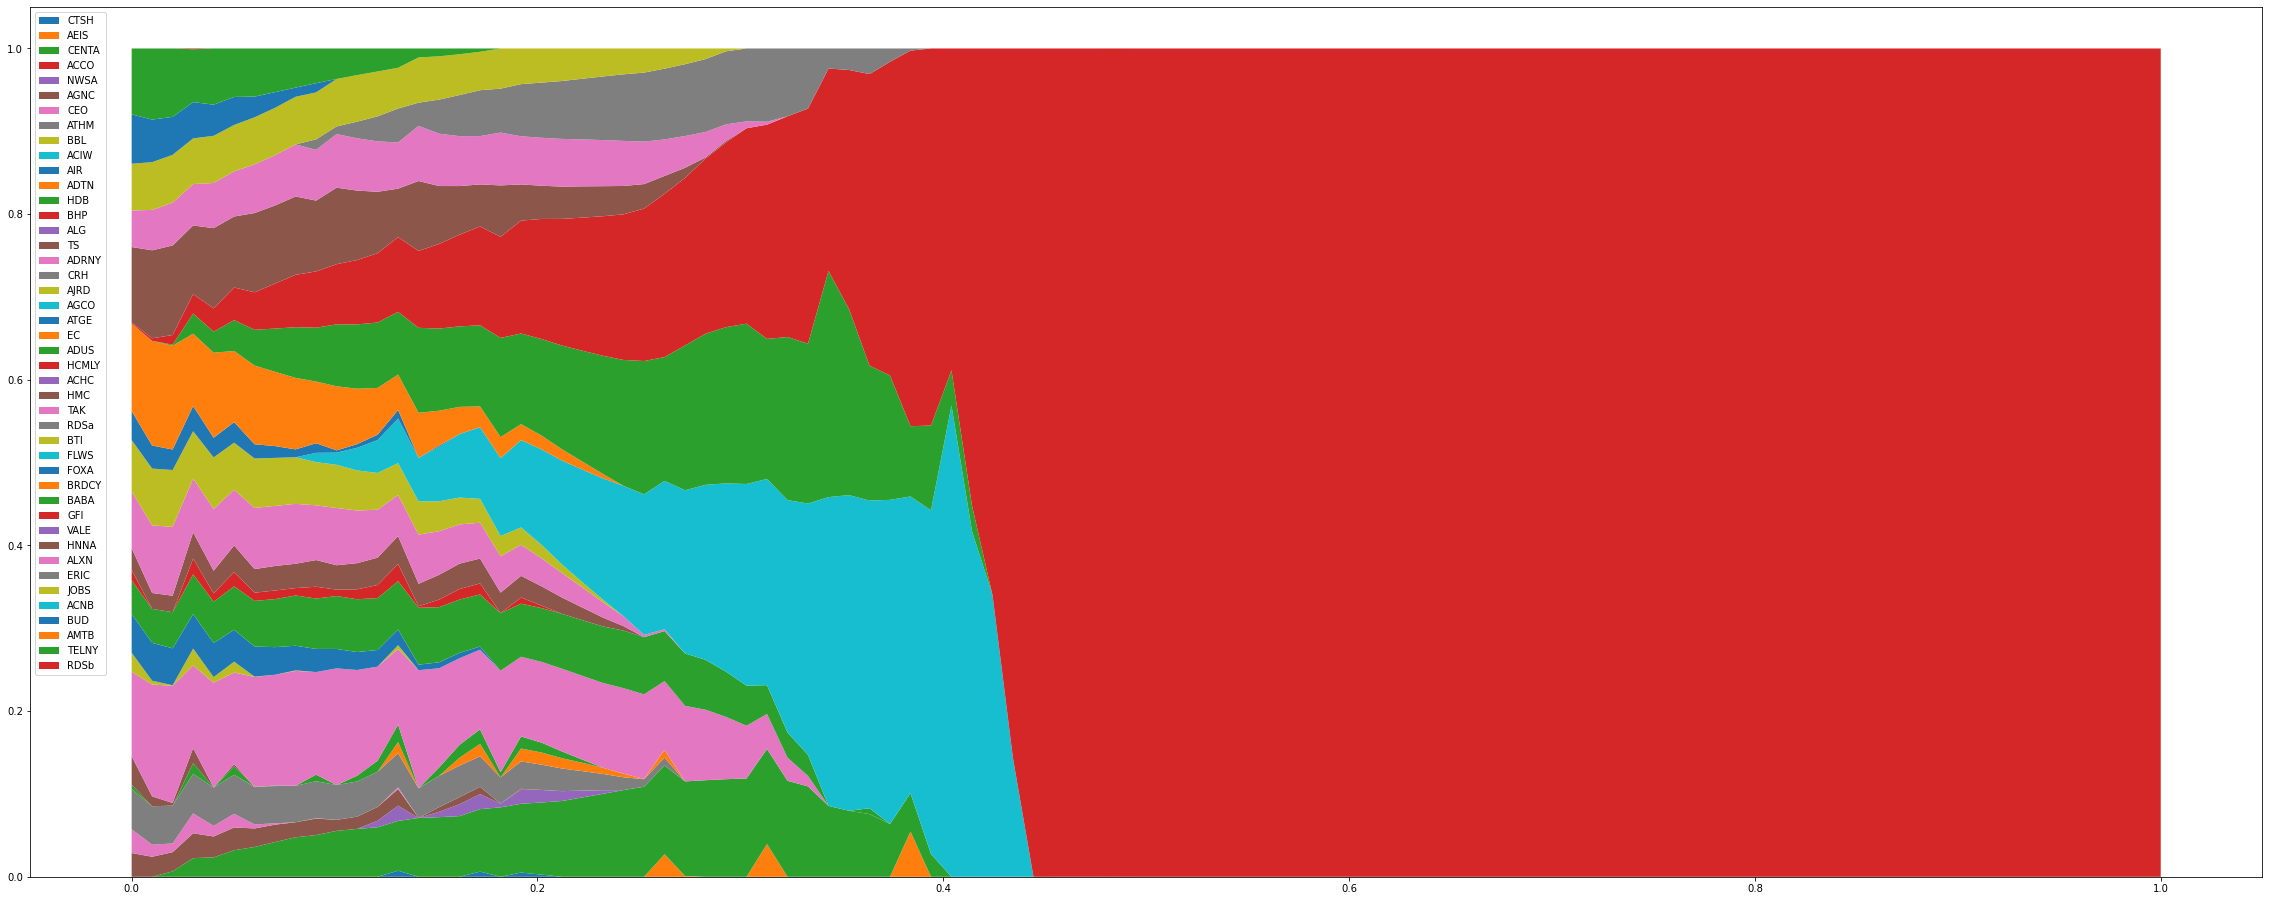

In [17]:
plt.figure(figsize=(40, 16))
plt.stackplot(rate, y, labels=labels)
plt.legend(loc='upper left')
plt.show()

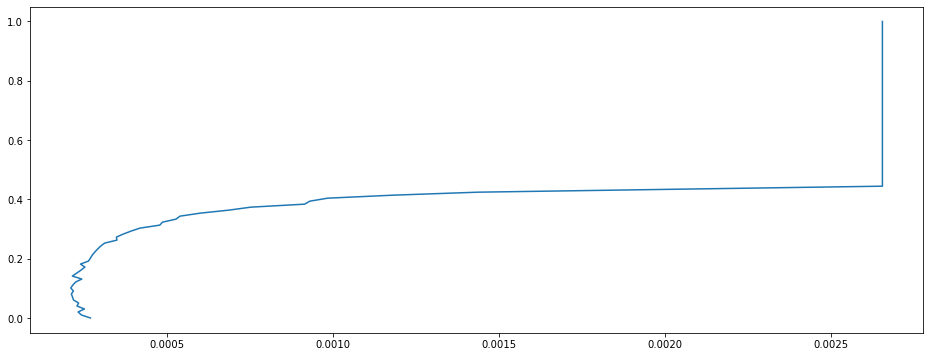

In [18]:
opti_vars = list(map(lambda res: res.fun, opti))
plt.figure(figsize=(16, 6))
plt.plot(opti_vars, rate)
plt.show()

In [19]:
def to_ndarray(stock_data):
    features = []
    features.append(list(map(lambda x: x.rsi, stock_data)))
    features.append(list(map(lambda x: x.volatility, stock_data)))
    features.append(list(map(lambda x: x.oscillation, stock_data)))
    features.append(list(map(lambda x: x.debt_to_equity, stock_data)))
    # features.append(list(map(lambda x: x.spearman, stock_data)))
    # features.append(list(map(lambda x: x.basic_eps, stock_data)))
    features.append(list(map(lambda x: x.pe_ratio, stock_data)))
    return np.array(features).T

In [20]:
stock_data_features = to_ndarray(stock_data)

In [21]:
def get_correlation(data, high_coef=0.8):
    coercoef = np.corrcoef(data.T)
    for (i, row) in enumerate(coercoef):
        for (j, val) in enumerate(row):
            if i < j and abs(val) >= high_coef:
                print('High correlation detected for features {} and {}'.format(i, j))
    return coercoef

In [22]:
get_correlation(stock_data_features)

array([[ 1.        , -0.07542447,  0.11728283, -0.12154404, -0.02654214],
       [-0.07542447,  1.        , -0.25226469, -0.18873948,  0.08625817],
       [ 0.11728283, -0.25226469,  1.        ,  0.11646842,  0.02999183],
       [-0.12154404, -0.18873948,  0.11646842,  1.        , -0.16556243],
       [-0.02654214,  0.08625817,  0.02999183, -0.16556243,  1.        ]])

In [23]:
sc = sklearn.preprocessing.StandardScaler()
sc.fit(stock_data_features)
stock_data_features_normalized = sc.transform(stock_data_features)

In [24]:
if False:
    print('KMeans')
    for n_clusters in range(2, 10):
        kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters)
        kmeans.fit(stock_data_features_normalized)
        labels = kmeans.labels_
        print(n_clusters, sklearn.metrics.silhouette_score(stock_data_features_normalized, labels, metric='euclidean'))

In [25]:
def draw_boxplot(X, labels, colors=None):
    # X[i] -- фичи для акции i
    # label[i] -- номер кластера акции i
    # X.shape = (#stocks, #features)

    fig, ax = plt.subplots(figsize=(10, 7))
    legend1, legend2 = [], []
    for label in range(1, max(labels) + 1):
        my = X[np.where(labels == label)]
        if colors is None:
            clr = list(np.random.random(3))
            clr2 = list(np.random.random(3))
        else:
            clr  = colors[label-1][0]
            clr2 = colors[label-1][1]
        bp = ax.boxplot(my, patch_artist=True)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=clr)
        for patch in bp['boxes']:
            patch.set(facecolor=clr2)
        legend1.append(bp["boxes"][0])
        legend2.append('Cluster ' + str(label-1))
    ax.legend(legend1, legend2)
    # plt.ylim(0, 1)
    plt.show()

In [26]:
def index_by_stock_data(stock_data_closes):
    # closes = []
    # for i in stock_data:
    #     closes.append(i.close)
    return scipy.stats.mstats.gmean(np.array(stock_data_closes))

In [28]:
from scipy.optimize import Bounds, minimize
import numpy as np
import matplotlib.pyplot as plt

def best_representative_of_cluster(stock_data, labels):
    stock_data_closes = []
    for stock_datum in stock_data:
        stock_data_closes.append(stock_datum.close)
    stock_data_closes = np.array(stock_data_closes)

    best_of_cluster = []
    for label in range(1, max(labels)+1):
        global_indices = np.array(list(range(len(stock_data))))[np.where(labels == label)]
        stock_data_closes_in_cluster = stock_data_closes[np.where(labels == label)]
        print("Cluster {}: {}".format(label, ' '.join(np.array(list(map(lambda x: x.stock, stock_data)))[np.where(labels == label)])))

        index_in_cluster = index_by_stock_data(stock_data_closes_in_cluster)

        x = np.ones(len(stock_data_closes_in_cluster)) * (1/len(stock_data_closes_in_cluster))

        def value(x):
            return (stock_data_closes_in_cluster.T @ x - index_in_cluster).std()

        sum_cons = {'type': 'eq',
                     'fun': lambda x: np.sum(x) - 1
                    }
        bnds = Bounds (np.zeros_like(x), np.ones_like(x))

        opti = minimize(value, x, method='SLSQP', constraints=[sum_cons], bounds=bnds)

        best_of_cluster.append((global_indices[np.argmax(opti.x)], np.max(opti.x)))
    return best_of_cluster

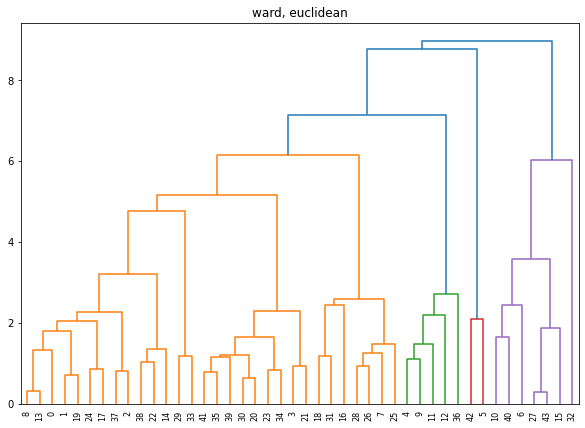

Method ward, Metric euclidean, Number of clusters 2, Silhouette 0.29296201469073335
Method ward, Metric euclidean, Number of clusters 3, Silhouette 0.337044803676698
Method ward, Metric euclidean, Number of clusters 4, Silhouette 0.281638258456754
Method ward, Metric euclidean, Number of clusters 5, Silhouette 0.2333555485808025
Method ward, Metric euclidean, Number of clusters 6, Silhouette 0.24877157788834534


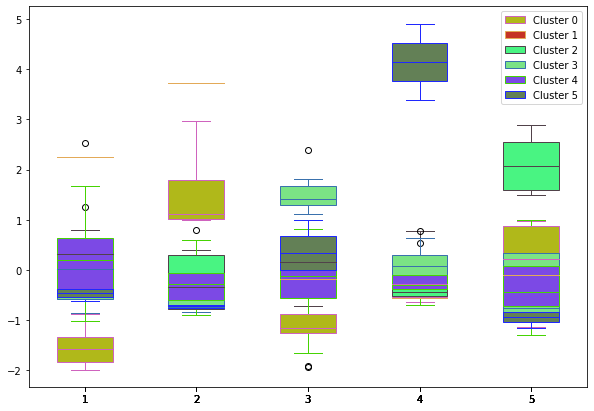

Cluster 1: CEO AIR TS RDSa BUD RDSb
Cluster 2: BABA
Cluster 3: NWSA ACIW ADTN HDB ALXN
Cluster 4: ATHM ADRNY AJRD HMC TAK BTI BRDCY
Cluster 5: CTSH AEIS CENTA ACCO BBL BHP ALG CRH AGCO ATGE EC ADUS HCMLY ACHC FLWS FOXA GFI VALE HNNA ERIC JOBS ACNB AMTB
Cluster 6: AGNC TELNY
Best representatives of clusters
Cluster 0: AIR with coefficient 0.289477595657885
Cluster 1: BABA with coefficient 1.0
Cluster 2: NWSA with coefficient 0.40403422919447424
Cluster 3: HMC with coefficient 0.2575610160015282
Cluster 4: ACCO with coefficient 0.1554928931909325
Cluster 5: AGNC with coefficient 0.5263507154238181


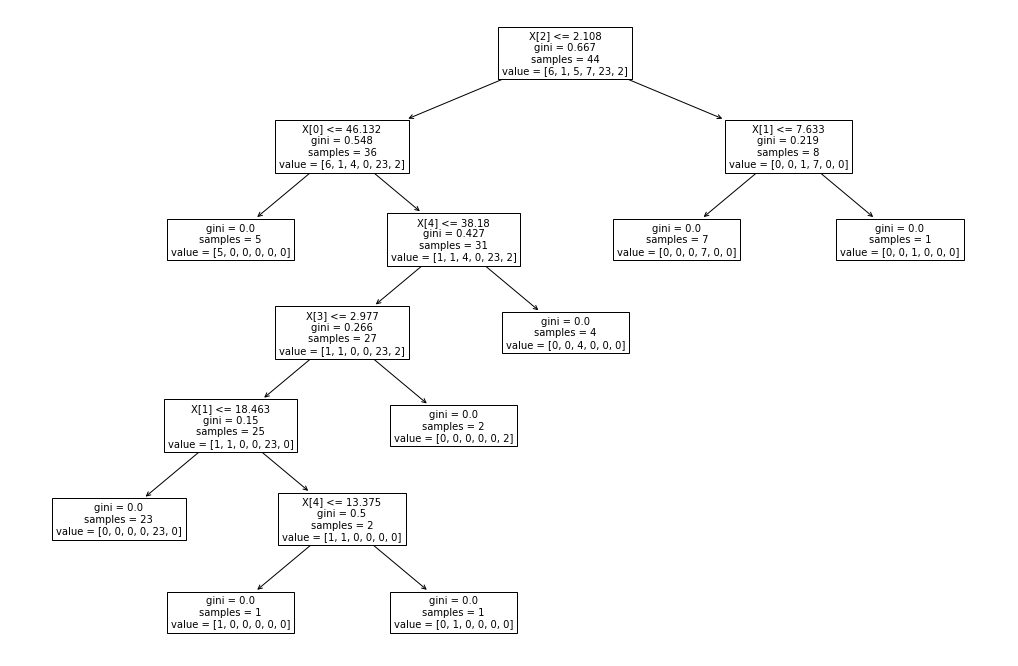

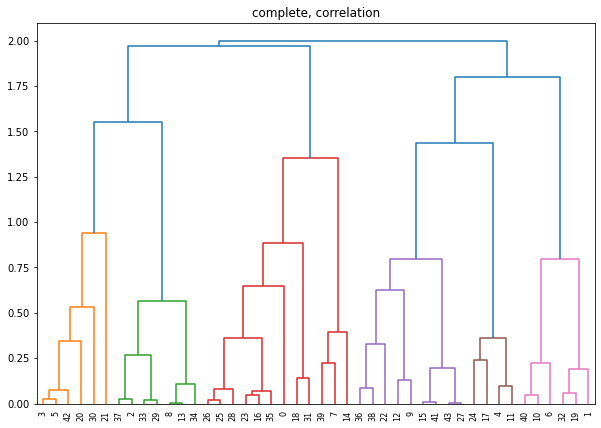

Method complete, Metric correlation, Number of clusters 2, Silhouette 0.3588420193796856
Method complete, Metric correlation, Number of clusters 3, Silhouette 0.29488790611825766
Method complete, Metric correlation, Number of clusters 4, Silhouette 0.3428617610184314
Method complete, Metric correlation, Number of clusters 5, Silhouette 0.4365472219236461
Method complete, Metric correlation, Number of clusters 6, Silhouette 0.4246845264736096


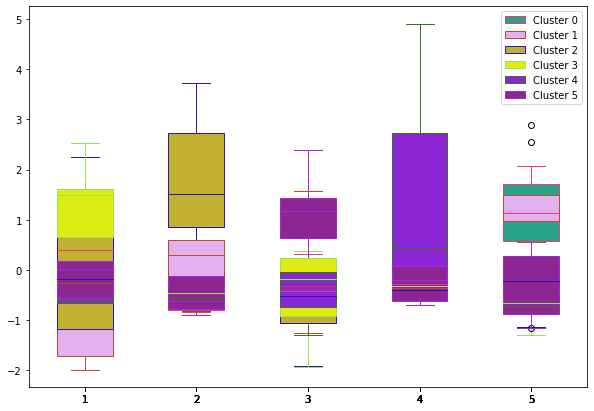

Cluster 1: NWSA ADTN CRH ACHC
Cluster 2: ACIW HDB TS ADUS RDSa ALXN JOBS AMTB RDSb
Cluster 3: AEIS CEO AIR AGCO BABA BUD
Cluster 4: CENTA BBL BHP FLWS GFI VALE ERIC
Cluster 5: ACCO AGNC ATGE EC FOXA TELNY
Cluster 6: CTSH ATHM ALG ADRNY AJRD HCMLY HMC TAK BTI BRDCY HNNA ACNB
Best representatives of clusters
Cluster 0: ADTN with coefficient 0.4054675324547154
Cluster 1: RDSb with coefficient 0.30801678040026553
Cluster 2: AIR with coefficient 0.2621115037631229
Cluster 3: GFI with coefficient 0.3544221451801118
Cluster 4: EC with coefficient 0.2772387185827757
Cluster 5: HNNA with coefficient 0.1917044564505513


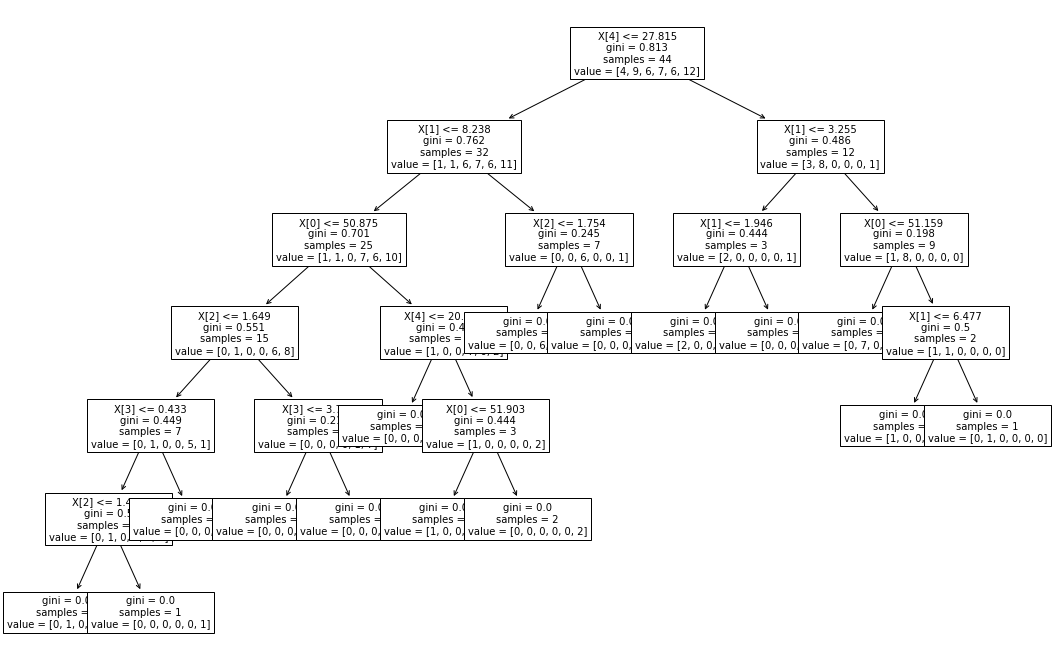

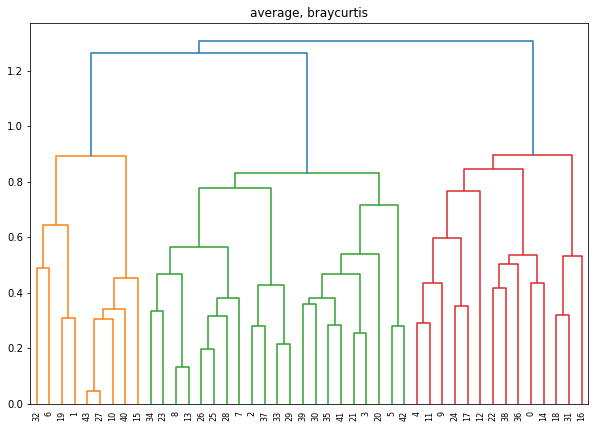

Method average, Metric braycurtis, Number of clusters 2, Silhouette 0.29265900284912855
Method average, Metric braycurtis, Number of clusters 3, Silhouette 0.30603695810882875
Method average, Metric braycurtis, Number of clusters 4, Silhouette 0.20139508161265196
Method average, Metric braycurtis, Number of clusters 5, Silhouette 0.1689779072657323
Method average, Metric braycurtis, Number of clusters 6, Silhouette 0.2048609321041722


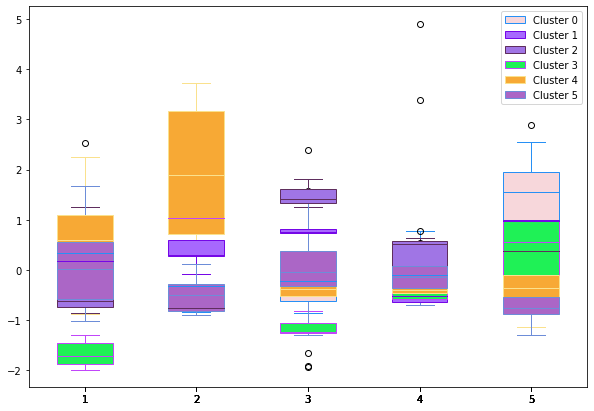

Cluster 1: NWSA ACIW ADTN HDB CRH ACHC
Cluster 2: CTSH ALG ADUS ALXN JOBS
Cluster 3: ADRNY AJRD BRDCY
Cluster 4: AIR TS RDSa BUD RDSb
Cluster 5: AEIS CEO AGCO BABA
Cluster 6: CENTA ACCO AGNC ATHM BBL BHP ATGE EC HCMLY HMC TAK BTI FLWS FOXA GFI VALE HNNA ERIC ACNB AMTB TELNY
Best representatives of clusters
Cluster 0: ADTN with coefficient 0.2757409401059624
Cluster 1: CTSH with coefficient 0.25637867584522356
Cluster 2: BRDCY with coefficient 0.49174585889103484
Cluster 3: AIR with coefficient 0.27132190636665005
Cluster 4: AGCO with coefficient 0.30429177522444056
Cluster 5: ACCO with coefficient 0.16244748944951096


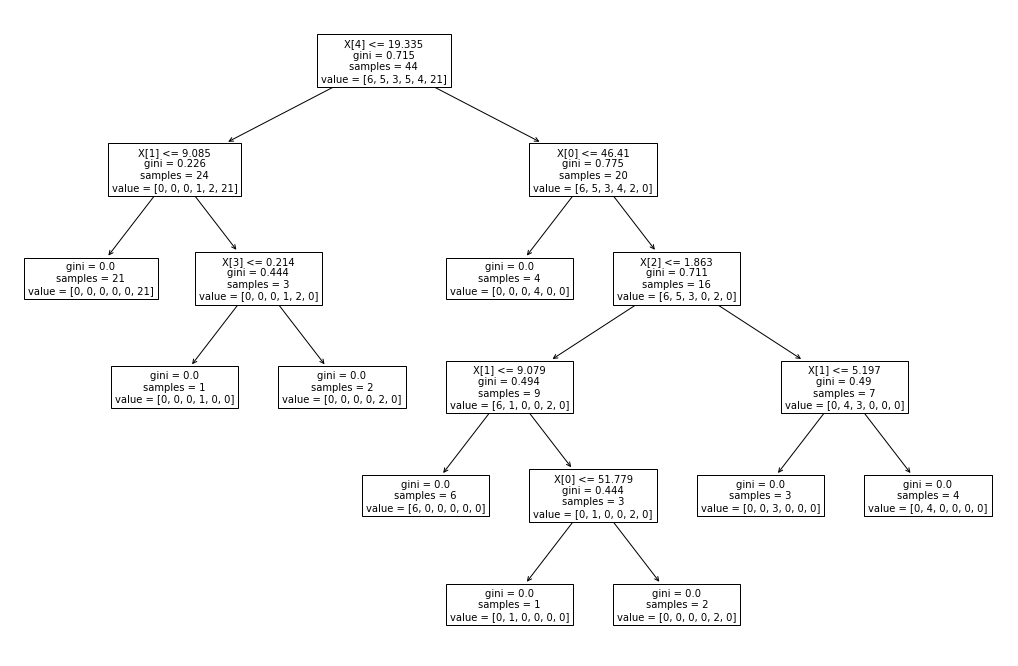

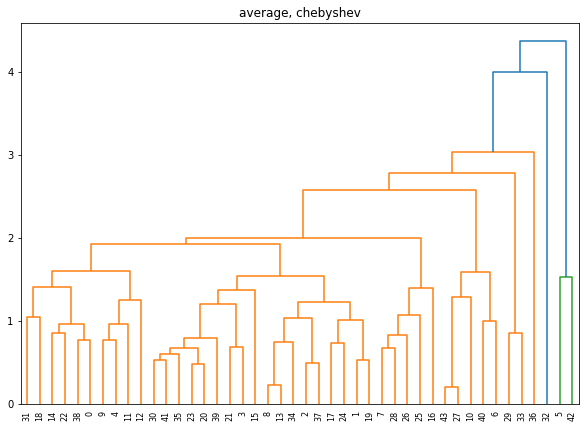

Method average, Metric chebyshev, Number of clusters 2, Silhouette 0.5153942012931432
Method average, Metric chebyshev, Number of clusters 3, Silhouette 0.4630926957464603
Method average, Metric chebyshev, Number of clusters 4, Silhouette 0.29879830036068583
Method average, Metric chebyshev, Number of clusters 5, Silhouette 0.2303823148904406
Method average, Metric chebyshev, Number of clusters 6, Silhouette 0.26576740511268787


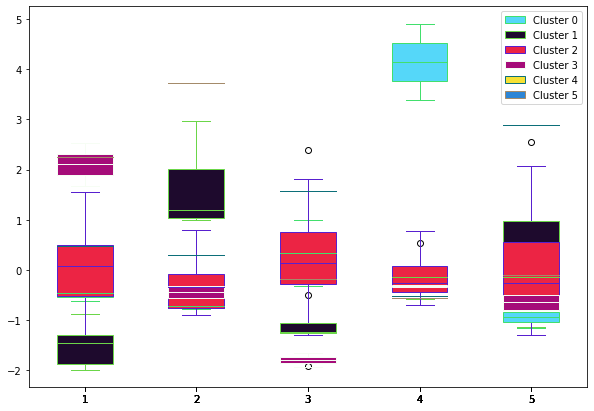

Cluster 1: AGNC TELNY
Cluster 2: CEO AIR RDSa BUD RDSb
Cluster 3: CTSH AEIS CENTA ACCO NWSA ATHM BBL ACIW ADTN HDB BHP ALG TS ADRNY CRH AJRD AGCO ATGE EC ADUS HCMLY ACHC HMC TAK BTI FOXA BRDCY VALE HNNA ERIC JOBS ACNB AMTB
Cluster 4: FLWS GFI
Cluster 5: ALXN
Cluster 6: BABA
Best representatives of clusters
Cluster 0: AGNC with coefficient 0.5263507154238181
Cluster 1: RDSb with coefficient 0.4262727956641701
Cluster 2: ACCO with coefficient 0.08787634185747605
Cluster 3: GFI with coefficient 0.6201397747833357
Cluster 4: ALXN with coefficient 1.0
Cluster 5: BABA with coefficient 1.0


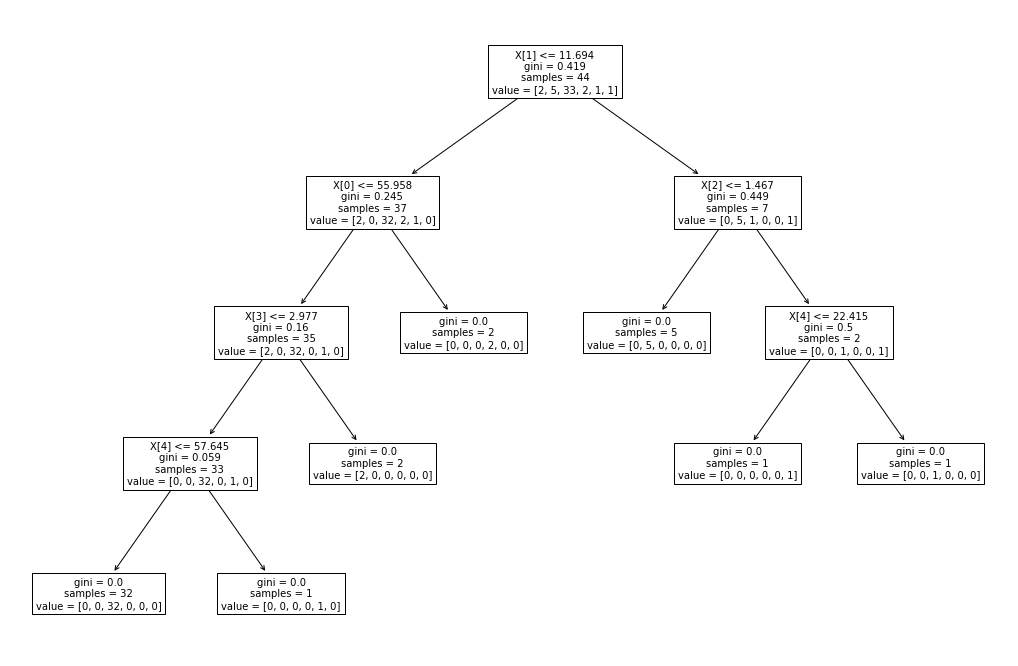

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import time

methods = ['single', 'ward', 'complete', 'average', 'weighted', 'centroid', 'median']
metrics =  ['braycurtis', 'canberra', 'chebyshev', 'cityblock',
            'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
            'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching',
            'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
            'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

def labels_by_linked(linked, n_clusters):
    return scipy.cluster.hierarchy.fcluster(linked, t=n_clusters, criterion='maxclust')

all_labels = []

for (method, metric) in [('ward', 'euclidean'), ('complete', 'correlation'), ('average', 'braycurtis'), ('average', 'chebyshev')]:
    linked = linkage(stock_data_features_normalized, method=method, metric=metric, optimal_ordering=True)

    labelList = range(0, len(stock_data_features_normalized))

    plt.figure(figsize=(10, 7))
    dendrogram(linked,
                orientation='top',
                labels=labelList,
                distance_sort='descending',
                show_leaf_counts=True)
    plt.title('{}, {}'.format(method, metric))
    plt.show()

    for n_clusters in range(2, 7):
        labels = labels_by_linked(linked, n_clusters)
        silhouette = sklearn.metrics.silhouette_score(stock_data_features_normalized, labels, metric=metric)
        print('Method {}, Metric {}, Number of clusters {}, Silhouette {}'.format(method, metric, n_clusters, silhouette))

    labels = labels_by_linked(linked, 6)
    all_labels.append(labels)
    # colors = [('tan', 'red'), ('blue', 'black'), ('green', 'cyan')]
    draw_boxplot(stock_data_features_normalized, labels)
    tree = sklearn.tree.DecisionTreeClassifier()
    tree.fit(stock_data_features, labels)
    plt.figure(figsize=(18, 12))
    sklearn.tree.plot_tree(tree, fontsize=10)
    best_of_cluster = best_representative_of_cluster(stock_data, labels)
    print('Best representatives of clusters')
    for (label, (i, coef)) in enumerate(best_of_cluster):
        print('Cluster {}: {} with coefficient {}'.format(label, stock_data[i].stock, coef))


In [30]:
if True:
    similiarity_scores = np.zeros((len(all_labels), len(all_labels)))
    for (i, l1) in enumerate(all_labels):
        for (j, l2) in enumerate(all_labels):
            similiarity_scores[i][j] = sklearn.metrics.homogeneity_score(l1, l2)
    print(similiarity_scores)

[[1.         0.49328773 0.55659311 0.46712012]
 [0.39196676 1.         0.52138585 0.24377716]
 [0.50415839 0.59434618 1.         0.27120552]
 [0.70221996 0.46119933 0.45010511 1.        ]]
